### Are we in SWAN?

In [ ]:
# Working in the right path
%cd /eos/project/d/da-and-diffusion-studies/DA_Studies/Simulations/Models/da_sixtrack/for_martin

In [ ]:
# Install the libraries
import sys
!{sys.executable} -m pip install --user sixtrackwrap
!export PYTHONPATH=$CERNBOX_HOME/.local/lib/python3.7/site-packages:$PYTHONPATH

In [ ]:
# For this "presentation" only!
import warnings
warnings.filterwarnings('ignore')

# Using SixTrackLib for Radial Scans

The main technique for extrapolating Dynamic Aperture ("Dynamic aperture estimates and phase-space distortions in nonlinear betatron motion" by E. Todesco and M. Giovannozzi) is the Radial Scanning process where, for various initial angular conditions, we scan particles at increasing radial distance from the reference orbit until we find an unstable particle.

GPU computing relies heavly on SIMD instruction with no efficient branching allowed. However, SixTrackLib implements various techniques for replacing known lost particles with other particles yet to be tracked, without loosing precious GPU computing power.

These efficient implementation allows us to instanciate many complete radial scans on an advanced Nvidia Tesla card without worrying "too much" of exploring too deeply an angle and ending up with particles that are lost almost immediatly. With a less efficient implementation, these particles would have become dead weight for an entire computing batch.

In this notebook, we display some stabilty plots we have made thanks to SixTrackLib.

## Import libraries

In [1]:
%matplotlib widget

In [1]:
# Base libraries
import math
import numpy as np
import scipy.integrate as integrate
from scipy.special import erf
import pickle
import itertools
from scipy.optimize import curve_fit

from numba import njit, prange

# Personal libraries
#import sixtrackwrap_light as sx
import sixtrackwrap as sx

from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import matplotlib
import matplotlib.ticker as ticker
from math import gcd

from scipy.special import lambertw

## Some stability plots

In [2]:
savepath = "data/"
engine = sx.radial_scanner.load_values(savepath + "big_scan.pkl")

min_turns = engine.min_time
max_turns = engine.max_time
n_turn_samples = 500

turn_sampling = np.linspace(min_turns, max_turns, n_turn_samples, dtype=np.int_)[::-1]

d_r = engine.dr
starting_step = engine.starting_step

# BASELINE COMPUTING
baseline_samples = 33
baseline_total_samples = baseline_samples ** 3

In [3]:
alpha_preliminary_values = np.linspace(-1.0, 1.0, baseline_samples)
alpha_values = np.arccos(alpha_preliminary_values) / 2
theta1_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)
theta2_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)

d_preliminar_alpha = alpha_preliminary_values[1] - alpha_preliminary_values[0]
d_theta1 = theta1_values[1] - theta1_values[0]
d_theta2 = theta2_values[1] - theta2_values[0]

alpha_mesh, theta1_mesh, theta2_mesh = np.meshgrid(alpha_values, theta1_values, theta2_values, indexing='ij')

alpha_flat = alpha_mesh.flatten()
theta1_flat = theta1_mesh.flatten()
theta2_flat = theta2_mesh.flatten()

In [5]:
fig3, ax3 = plt.subplots()
cmap3 = matplotlib.cm.get_cmap('viridis')
norm3 = matplotlib.colors.Normalize(vmin=np.log10(turn_sampling[-1]), vmax=np.log10(turn_sampling[0]))
fig3.colorbar(matplotlib.cm.ScalarMappable(norm=norm3, cmap=cmap3), label='Number of stable turns considered\n$[\\log_{10}(N_{turns})]$')

radiuses = engine.extract_DA(turn_sampling)
radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))

radiuses = radiuses[:, 0, 0, :]

for i in list(range(radiuses.shape[-1]))[::-1]:
    value = np.log10(turn_sampling[i] - turn_sampling[-1]) / np.log10(turn_sampling[0] - turn_sampling[-1])
    x = radiuses[:,i] * np.cos(alpha_values)
    y = radiuses[:,i] * np.sin(alpha_values)
    x = np.concatenate(([0], x))
    y = np.concatenate(([0], y))
    ax3.fill(x, y, c=cmap3(value))

ax3.set_title("LHC lattice (no bb interaction). Stable region.")
ax3.set_xlabel("$x$ [$\\sigma$ units]")
ax3.set_ylabel("$y$ [$\\sigma$ units]")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/carlidel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


Text(0, 0.5, '$y$ [$\\sigma$ units]')

In [6]:
fig4 = plt.figure()
cmap4 = matplotlib.cm.get_cmap('viridis')
norm4 = matplotlib.colors.Normalize(vmin=np.log10(turn_sampling[-1]), vmax=np.log10(turn_sampling[0]))
fig4.colorbar(matplotlib.cm.ScalarMappable(norm=norm4, cmap=cmap4), label='Number of stable turns considered\n$[\\log_{10}(N_{turns})]$')


def update4(idx1, idx2):
    radiuses = engine.extract_DA(turn_sampling)
    radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))

    fig4.clear()
    ax4 = fig4.subplots(1, 2) 
    fig4.colorbar(matplotlib.cm.ScalarMappable(norm=norm4, cmap=cmap4), label='Number of stable turns considered\n$[\\log_{10}(N_{turns})]$')
    radiuses = radiuses[:, idx1, idx2, :]

    for i in list(range(radiuses.shape[-1]))[::-1]:
        value = np.log10(turn_sampling[i] - turn_sampling[-1]) / np.log10(turn_sampling[0] - turn_sampling[-1])
        x = radiuses[:,i] * np.cos(alpha_values) * np.cos(theta1_values[idx1])
        px = radiuses[:,i] * np.cos(alpha_values) * np.sin(theta1_values[idx1])
        y = radiuses[:,i] * np.sin(alpha_values) * np.cos(theta2_values[idx2])
        py = radiuses[:,i] * np.sin(alpha_values) * np.sin(theta2_values[idx2])
        x = np.concatenate(([0], x))
        px = np.concatenate(([0], px))
        y = np.concatenate(([0], y))
        py = np.concatenate(([0], py))
        ax4[0].fill(x, y, c=cmap4(value))
        ax4[1].fill(px, py, c=cmap4(value))

    fig4.suptitle("LHC lattice (no bb interaction). Stable region.\n4D view. Slice considered: $(\\theta_1={:.2}\\pi, \\theta_2={:.2}\\pi)$".format(theta1_values[idx1]/np.pi, theta2_values[idx2]/np.pi))
    ax4[0].set_xlabel("$x$ [$\\sigma$ units]")
    ax4[0].set_ylabel("$y$ [$\\sigma$ units]")
    ax4[1].set_xlabel("$px$ [$\\sigma$ units]")
    ax4[1].set_ylabel("$py$ [$\\sigma$ units]")

a=widgets.IntSlider(value=0, min=0, max=len(theta1_values) - 1, step=1, continuous_update=False)
b=widgets.IntSlider(value=0, min=0, max=len(theta2_values) - 1, step=1, continuous_update=False)
ui = widgets.VBox([
    widgets.Label("$\\theta_1$ slice index"), a,
    widgets.Label("$\\theta_2$ slice index"), b])
    
out = widgets.interactive_output(
    update4,
    {"idx1":a, "idx2":b}
)

display(ui, out)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Output()

## Exploring and visualizing 3D samples of DA!

This is a rather unfinished interactive plot I (Carlo Emilio) am working on.

With this tool, you can (somewhat) visualize the angular dependencies of DA by moving the $\theta_1$ and $\theta_2$ sliders and setting up 3D samples of different dimension (the resulting sample is sample_size ** 3 big).

What you will then visualize is the evolution of DA with the number of turns, considering different $\alpha$ angles ($\alpha$ indicates the central angle of the considered sample).

**N.B.: the plotting process requires time, so after moving the sliders you will need to wait a little!**

In [7]:
fig, ax = plt.subplots()
cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=np.log10(turn_sampling[-1]), vmax=np.log10(turn_sampling[0]))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), label='Number of stable turns considered\n$[\\log_{10}(N_{turns})]$')

radiuses = engine.extract_DA(turn_sampling)
radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))

@njit
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

@njit
def take_sample(array, value, size):
    assert size % 2 == 0
    array = np.asarray(array)
    idx = find_nearest(array, value)
    if idx < size:
        return 0, size
    elif idx >= len(array) - size:
        return len(array) - size, len(array)
    else:
        return idx - size // 2, idx + size // 2

def update1(sample_size, th1, th2, n_to_visualize):
    th1 *= np.pi
    th2 *= np.pi
    y_values = np.empty((len(range(sample_size, len(alpha_preliminary_values))), len(turn_sampling)))
    x_values = np.empty((len(range(sample_size, len(alpha_preliminary_values)))))
    x_err_values = np.empty((len(range(sample_size, len(alpha_preliminary_values)))))

    th1_min, th1_max = take_sample(theta1_values, th1, sample_size)
    th2_min, th2_max = take_sample(theta2_values, th2, sample_size)
    theta1_sample = theta1_values[th1_min : th1_max]
    theta2_sample = theta1_values[th2_min : th2_max]

    mod_radiuses = np.power(radiuses, 4)[:, th1_min : th1_max, th2_min : th2_max]
    mod_radiuses = integrate.simps(mod_radiuses, x=theta1_sample, axis=1)
    mod_radiuses = integrate.simps(mod_radiuses, x=theta2_sample, axis=1)
    
    DA_whole = (
        np.power(
            mod_radiuses / (
                (theta1_sample[-1] - theta1_sample[0]) 
                * (theta2_sample[-1] - theta2_sample[0])),
            1/4
        )
    )

    for i, a_max in enumerate(range(sample_size, len(alpha_preliminary_values))):
        a_min = a_max - sample_size
        alpha_sample = alpha_preliminary_values[a_min : a_max]
        a_mid = (alpha_values[a_min] + alpha_values[a_max]) / 2
        
        s_radiuses = mod_radiuses[a_min : a_max]
        s_radiuses = integrate.simps(s_radiuses, x=alpha_sample, axis=0)

        DA = (
            np.power(
                s_radiuses / (
                    (alpha_sample[-1] - alpha_sample[0]) 
                    * (theta1_sample[-1] - theta1_sample[0]) 
                    * (theta2_sample[-1] - theta2_sample[0])),
                1/4
            )
        )
        y_values[i] = DA
        x_values[i] = a_mid
        x_err_values[i] = a_mid - alpha_values[a_min]
        
    y_values = np.asarray(y_values)
    y_values = y_values.transpose()
    x_values = np.asarray(x_values)
    ax.clear()
    for i in np.unique(np.logspace(0, np.log10(n_turn_samples), n_to_visualize, dtype=np.int)):
    #for i in np.linspace(0, n_turn_samples, 5, dtype=np.int, endpoint=False):
        if i == n_turn_samples:
            i -= 1
        value = np.log10(turn_sampling[i] - turn_sampling[-1]) / np.log10(turn_sampling[0] - turn_sampling[-1])
        # whole stuff (integrated only over thetas)
        ax.plot(alpha_values, DA_whole[:, i], c=cmap(value), linewidth=0.5, alpha=0.8)
        # points
        ax.errorbar(x_values, y_values[i], xerr=(x_err_values), linewidth=0, elinewidth=0.5, c=cmap(value), capsize=0.5, capthick=0.5, marker="*", markeredgecolor="grey")
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("Measured $DA$ in sample")
    ax.set_title("DA evolution over $\\alpha$ for a moving average of ${}^3$ elements (total is ${}^3$)\nThis implies {} DA computations over the given $\\theta_1, \\theta_2$ slice.\n$\\theta$ slice considered: $(\\theta_1 = {:.2f}\\pi, \\theta_2 = {:.2f}\\pi)$".format(sample_size, baseline_samples, baseline_samples - sample_size, th1/np.pi, th2/np.pi, baseline_samples))
    #ax.set_ylim(np.min(radiuses), np.max(radiuses))
    ax.set_xlim(0.0, np.pi / 2.0)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: ("$\\frac{{{}}}{{{}}}$".format(int(x/(np.pi/8)) // gcd(8, int(x/(np.pi/8))), 8 // gcd(8, int(x/(np.pi/8)))) if x != 0 else "0") + "$\\pi$"
        )
    )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=np.pi/8))
    plt.tight_layout()


a=widgets.IntSlider(value=4, min=2, max=baseline_samples - 4, step=2, continuous_update=False)
b=widgets.FloatSlider(value=1, min=0, max=2 + 0.01, step=0.01, continuous_update=False)
c=widgets.FloatSlider(value=1, min=0, max=2 + 0.01, step=0.01, continuous_update=False)
d=widgets.IntSlider(value=2, min=2, max=n_turn_samples, step=1, continuous_update=False)
ui = widgets.VBox([
    widgets.Label("Number of turn samples to visualize"), d,
    widgets.Label("Size of the cubic sample"), a,
    widgets.Label("$\\theta_1$ value $[\\pi$ units$]$"), b,
    widgets.Label("$\\theta_2$ value $[\\pi$ units$]$"), c])
    
out = widgets.interactive_output(
    update1,
    {"sample_size":a, "th1":b, "th2":c, "n_to_visualize":d}
)

display(ui, out)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Output()

### A few notes on how to read the plot above
* On the sampling of the $\alpha$ angle: since in our 4D polar coordinates we have a non unitary jacobian for the $\alpha$ variable, the sampling over $\alpha$ was performed not uniformely, but it is balanced over the jacobian value (i.e. we sampled uniformely over the variable $y = \cos 2\alpha$, for $y \in [-1,1]$), so that the amount of information obtained is maximized.
* The continuous lines you see in the background of the plot are the average radial values computed for the corresponding $\alpha$ angle and a sample of sample_sizeXsample_size dimension centered on the corresponding $\theta_1, \theta_2$ angles chosen.
* The horizontal lines with dots represent an averaging integration over the corresponding $\alpha$ interval

## DA fittings and beam loss comparisons

### Model 2

$$D(N) = \rho_\ast \left(\frac{\kappa}{2e}\right)^\kappa \frac{1}{\ln^\kappa\frac{N}{N_0}}$$


In [4]:
def model_2(x, rho, n0, k):
    return rho * np.power(k / (2 * np.exp(1)), k) / (np.power(np.log(x / n0), k))

In [ ]:
with open("data/data_from_fits.pkl", 'rb') as f:
    turn_sampling, DA, _, real_selected_pars_2, real_selected_co_pars_2, real_selected_k_2, dk = pickle.load(f)

Text(0.5, 1.0, 'LHC DA evolution and fitting model 2')

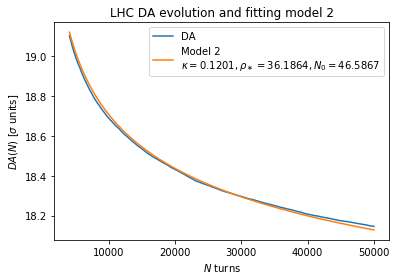

In [6]:
fig1, ax1 = plt.subplots()
skipper=40
ax1.plot(turn_sampling[:-skipper], DA[:-skipper], label="DA")
ax1.plot(turn_sampling[:-skipper], model_2(turn_sampling, real_selected_pars_2[0], real_selected_pars_2[1], real_selected_k_2)[:-skipper], label="Model 2\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(real_selected_k_2, real_selected_pars_2[0], real_selected_pars_2[1]), c="C1")

ax1.legend()
ax1.set_xlabel("$N$ turns")
ax1.set_ylabel("$DA(N)$ [$\\sigma$ units]")
ax1.set_title("LHC DA evolution and fitting model 2")